In [1]:
import numpy as np
import math
import h5py
import keras
import matplotlib.pyplot as plt
from keras.models import Sequential
from keras.layers import Conv2D, Input, BatchNormalization
from keras.callbacks import ModelCheckpoint,EarlyStopping
from keras.optimizers import SGD, Adam

Using TensorFlow backend.


In [2]:
# write a LossHistory Class to record loss and accuracy.
class LossHistory(keras.callbacks.Callback):
    
    def on_train_begin(self, logs = {}):
        self.losses = {'batch': [], 'epoch': []}
        self.val_loss = {'batch': [], 'epoch': []}
        
    def on_batch_end(self, batch, logs = {}):
        self.losses['batch'].append(logs.get('loss'))
        self.val_loss['batch'].append(logs.get('val_loss'))
        
    def on_epoch_end(self, batch, logs = {}):
        self.losses['epoch'].append(logs.get('loss'))
        self.val_loss['epoch'].append(logs.get('val_loss'))
        
    def loss_plot(self, loss_type):
        
        iters = range(len(self.losses[loss_type]))
        
        plt.figure()
        plt.plot(iters, self.losses[loss_type], 'g', label = 'train loss')
        
        if loss_type == 'epoch':
            # acc
            plt.plot(iters, self.accuracy[loss_type], 'r', label = 'train acc')
            # loss
            plt.plot(iters, self.losses[loss_type], 'g', label = 'train loss')
            # val_acc
            plt.plot(iters, self.val_acc[loss_type], 'b', label = 'val acc')
            # val_loss
            plt.plot(iters, self.val_loss[loss_type], 'k', label = 'val loss')
            
        plt.grid(True)
        plt.xlabel(loss_type)
        plt.ylabel('loss')
        plt.legend(loc = 'upper right')
        plt.show()

# Train Model

In [3]:
SRCNN = Sequential()
SRCNN.add(
    Conv2D(
        filters = 256,
        kernel_size = (9, 9),
        padding = 'valid',
        activation = 'relu',
        use_bias = True,
        kernel_initializer = 'glorot_uniform',
        input_shape = (None, None, 1)))
SRCNN.add(
    Conv2D(
        filters = 128,
        kernel_size = (3, 3),
        padding = 'same',
        activation = 'relu',
        use_bias = True,
        kernel_initializer = 'glorot_uniform'))
SRCNN.add(
    Conv2D(
        filters = 256,
        kernel_size = (1, 1),
        padding = 'same',
        activation = 'relu',
        use_bias = True,
        kernel_initializer = 'glorot_uniform'))
SRCNN.add(
    Conv2D(
        filters = 1,
        kernel_size = (5, 5),
        padding = 'valid',
        use_bias = True,
        kernel_initializer = 'glorot_uniform'))
adam = Adam(lr = 0.001)
SRCNN.compile(optimizer = adam, loss = 'mean_squared_error', metrics = ['mean_squared_error'])

In [4]:
def read_training_data(file):
    with h5py.File(file, 'r') as hf:
        data = numpy.array(hf.get('data'))
        label = numpy.array(hf.get('label'))
        return data, label

In [5]:
print(SRCNN.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, None, None, 256)   20992     
_________________________________________________________________
conv2d_2 (Conv2D)            (None, None, None, 128)   295040    
_________________________________________________________________
conv2d_3 (Conv2D)            (None, None, None, 256)   33024     
_________________________________________________________________
conv2d_4 (Conv2D)            (None, None, None, 1)     6401      
Total params: 355,457
Trainable params: 355,457
Non-trainable params: 0
_________________________________________________________________
None


In [6]:
data,label = read_training_data("./doc/crop_train.h5")

In [7]:
checkpoint = ModelCheckpoint(
    "SRCNN_check.h5",
    monitor='loss',
    verbose=1,
    save_best_only=True,
    save_weights_only=False,
    mode='min')
earlystop=EarlyStopping(monitor='loss',patience=3)
history=LossHistory()
callbacks_list = [checkpoint,earlystop,history]
SRCNN.fit(
    data,
    label,
    batch_size=256,
    callbacks=callbacks_list,
    shuffle=True,
    epochs=6)

Epoch 1/6
1510997/1510997 [==============================] - 316s 209us/step - loss: 0.0025 - mean_squared_error: 0.0025
Epoch 2/6
1510997/1510997 [==============================] - 313s 207us/step - loss: 0.0022 - mean_squared_error: 0.0022
Epoch 3/6
1510997/1510997 [==============================] - 312s 207us/step - loss: 0.0021 - mean_squared_error: 0.0021
Epoch 4/6
1510997/1510997 [==============================] - 312s 207us/step - loss: 0.0021 - mean_squared_error: 0.0021
Epoch 5/6
1510997/1510997 [==============================] - 312s 207us/step - loss: 0.0021 - mean_squared_error: 0.0021
Epoch 6/6
1510997/1510997 [==============================] - 312s 207us/step - loss: 0.0021 - mean_squared_error: 0.0021


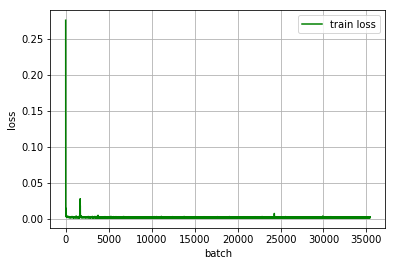

In [8]:
history.loss_plot('batch')
plt.show()

# Predict test

In [4]:
from keras.models import  load_model
import numpy
SRCNN=load_model('./doc/SRCNN_check.h5')

In [7]:
import cv2
LR_IMG_NAME='./data/train_set/LR/img_0001.jpg'
HR_IMG_NAME='./data/train_set/HR/img_0001.jpg'
OUTPUT_NAME='./output/test.jpg'
img = cv2.imread(LR_IMG_NAME)
print(img.shape)
shape=img.shape
img=cv2.resize(img,(shape[1]*2,shape[0]*2),cv2.INTER_CUBIC)
cv2.imwrite('./output/resized.jpg',img)
img = cv2.cvtColor(img, cv2.COLOR_BGR2YCrCb)
X = numpy.zeros((1, img.shape[0], img.shape[1], 1), dtype=float)
X[0, :, :, 0] = img[:,:,0].astype(float) /255.
pre = SRCNN.predict(X, batch_size=1)*255.
print(pre.shape)
pre[pre[:] > 255] = 255
pre[pre[:] < 0] = 0
pre = pre.astype(numpy.uint8)
img[6: -6, 6: -6, 0] = pre[0, :, :, 0]
img = cv2.cvtColor(img, cv2.COLOR_YCrCb2BGR)
print(img.shape)
cv2.imwrite(OUTPUT_NAME, img)
cv2.imwrite('./output/hr.jpg',cv2.imread(HR_IMG_NAME))

(215, 284, 3)
(1, 418, 556, 1)
(430, 568, 3)


True

# Predict all images

In [ ]:
def get_all_results(filepath):
    for file in os.listdir(filepath):
        if not os.path.exists('./SRCNN_predicted'):
            os.makedirs('./SRCNN_predicted')
        OUPUT_dir='./SRCNN_predicted'
        LR_IMG_NAME=os.path.join(filepath,file)
        OUTPUT_NAME=os.path.join(OUPUT_dir,file)
        img = cv2.imread(LR_IMG_NAME)
#         print(img.shape)
        shape=img.shape
        img=cv2.resize(img,(shape[1]*2,shape[0]*2),cv2.INTER_CUBIC)
#         cv2.imwrite('./resized.jpg',img)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2YCrCb)
        X = numpy.zeros((1, img.shape[0], img.shape[1], 1), dtype=float)
        X[0, :, :, 0] = img[:,:,0].astype(float) /255.
        pre = SRCNN.predict(X, batch_size=1)*255.
#         print(pre.shape)
        pre[pre[:] > 255] = 255
        pre[pre[:] < 0] = 0
        pre = pre.astype(numpy.uint8)
        img[6: -6, 6: -6, 0] = pre[0, :, :, 0]
        img = cv2.cvtColor(img, cv2.COLOR_YCrCb2BGR)
#         print(img.shape)
        cv2.imwrite(OUTPUT_NAME, img)
    print('Super Resolution completed')

In [ ]:
get_all_results(filepath='./train_set/LR/')